In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F
import math


# 1. Data Preprocessing
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.FloatTensor(features)
        self.labels = torch.FloatTensor(labels)
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

class ComplexTransformerAutoencoder(nn.Module):
    def __init__(self, 
                 input_dim=21,
                 d_model=256,
                 nhead=8,
                 num_encoder_layers=6,
                 dim_feedforward=512,
                 dropout=0.2,
                 activation="gelu"):
        super(ComplexTransformerAutoencoder, self).__init__()
        
        # Input Processing
        self.input_embedding = nn.Sequential(
            nn.Linear(input_dim, d_model//2),
            nn.LayerNorm(d_model//2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model//2, d_model),
            nn.LayerNorm(d_model)
        )
        
        # Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            activation=activation,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer, 
            num_layers=num_encoder_layers,
            norm=nn.LayerNorm(d_model)
        )
        
        # Decoder Head
        self.decoder_head = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.LayerNorm(dim_feedforward),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, input_dim),
            nn.Sigmoid()
        )
        
        # Classifier Head
        self.classifier = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.LayerNorm(dim_feedforward),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, 64),
            nn.LayerNorm(64),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        batch_size = x.size(0)
        
        # Input embedding
        x = self.input_embedding(x)
        
        # Add sequence dimension if needed
        if len(x.shape) == 2:
            x = x.unsqueeze(1)
        
        # Encoder
        encoded = self.transformer_encoder(x)
        
        # Decoder head (ensure correct dimensions)
        reconstruction = self.decoder_head(encoded.squeeze(1))  # Remove sequence dimension
        
        # Classifier head
        classification = self.classifier(encoded.mean(dim=1))  # Mean pooling across sequence
        
        # Ensure reconstruction has same dimensions as input
        reconstruction = reconstruction.view(batch_size, -1)  # Reshape to match input
        
        return reconstruction, classification

class TransformerAutoencoder(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_encoder_layers, dim_feedforward):
        super(TransformerAutoencoder, self).__init__()
        
        # Encoder
        self.input_linear = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, 
                                                 nhead=nhead,
                                                 dim_feedforward=dim_feedforward,batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, 
                                                       num_layers=num_encoder_layers)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.ReLU(),
            nn.Linear(dim_feedforward, input_dim),
            nn.Sigmoid()
        )
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(d_model, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        # Add sequence dimension
        x = x.unsqueeze(0)
        
        # Encoder
        x = self.input_linear(x)
        latent = self.transformer_encoder(x)
        
        # Decoder
        decoded = self.decoder(latent.squeeze(0))
        
        # Classifier
        classification = self.classifier(latent.squeeze(0))
        
        return decoded, classification
        
class HybridEnsembleAutoencoder(nn.Module):
    def __init__(self, input_dim=21):
        super(HybridEnsembleAutoencoder, self).__init__()
        
        # Simple Transformer Autoencoder
        self.simple_model = TransformerAutoencoder(
            input_dim=input_dim,
            d_model=64,
            nhead=4,
            num_encoder_layers=2,
            dim_feedforward=128
        )
        
        # Complex Transformer Autoencoder
        self.complex_model = ComplexTransformerAutoencoder(
            input_dim=input_dim,
            d_model=256,
            nhead=8,
            num_encoder_layers=6,
            dim_feedforward=512,
            dropout=0.2,
            activation="gelu"
        )
        
        # Learnable weights for ensemble
        self.classification_weights = nn.Parameter(torch.ones(2) / 2)  # Initialize with equal weights
        self.reconstruction_weights = nn.Parameter(torch.ones(2) / 2)
        
    def forward(self, x):
        # Get predictions from simple model
        simple_recon, simple_clf = self.simple_model(x)
        
        # Get predictions from complex model
        complex_recon, complex_clf = self.complex_model(x)
        
        # Calculate ensemble weights
        clf_weights = F.softmax(self.classification_weights, dim=0)
        recon_weights = F.softmax(self.reconstruction_weights, dim=0)
        
        # Weighted ensemble predictions
        ensemble_classification = (
            clf_weights[0] * simple_clf + 
            clf_weights[1] * complex_clf
        )
        
        ensemble_reconstruction = (
            recon_weights[0] * simple_recon + 
            recon_weights[1] * complex_recon
        )
        
        return ensemble_reconstruction, ensemble_classification

from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    auc
)

def evaluate_hybrid_ensemble(ensemble, test_loader, device='cuda'):
    """
    Evaluate the hybrid ensemble model with detailed metrics and plots
    """
    ensemble.eval()
    predictions = []
    labels = []
    total_loss = 0
    recon_criterion = nn.MSELoss()
    class_criterion = nn.BCELoss()
    with torch.no_grad():
        for features, target in test_loader:
            features = features.to(device)
            target = target.to(device)
            
            # Get ensemble predictions
            reconstruction, classification = ensemble(features)

            recon_loss = recon_criterion(reconstruction, features)
            class_loss = class_criterion(classification.squeeze(), target)
            loss = 0.5 * recon_loss + 0.5 * class_loss
            total_loss += loss.item()
            
            predictions.append(classification.squeeze().cpu().numpy())
            labels.append(target.cpu().numpy())
    
    # Convert to numpy arrays
    predictions = np.concatenate(predictions)
    labels = np.concatenate(labels)
    
    # Find optimal threshold using ROC curve
    fpr, tpr, thresholds = roc_curve(labels, predictions)
    auc_score = auc(fpr, tpr)
    
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    
    # Get binary predictions using optimal threshold
    binary_preds = (predictions >= optimal_threshold).astype(int)
    
    metrics = {
            'Loss': total_loss / len(test_loader),
            'AUC Score': auc_score,
            'Optimal Threshold': optimal_threshold,
            'Precision': precision_score(labels, binary_preds),
            'Recall': recall_score(labels, binary_preds),
            'F1 Score': f1_score(labels, binary_preds),
            'Accuracy': accuracy_score(labels, binary_preds)
        }
    
    # if plot:
    #     # Plot confusion matrix
    #     plot_confusion_matrix(all_labels, all_preds, 
    #                         title='Hybrid Ensemble Confusion Matrix')
        
    #     # Plot ROC curve
    #     plot_roc_curve(all_labels, all_preds_proba, 
    #                   title='Hybrid Ensemble ROC Curve')
    
    return metrics

# def train_complex_model(model, train_loader, val_loader, num_epochs=50):
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     model = model.to(device)
    
#     # Optimizer
#     optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
    
#     # Scheduler
#     scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
#         optimizer, T_0=10, T_mult=2
#     )
    
#     # Loss functions
#     recon_criterion = nn.MSELoss()
#     class_criterion = nn.BCELoss()
    
#     for epoch in range(num_epochs):
#         model.train()
#         total_loss = 0
        
#         for batch_idx, (features, labels) in enumerate(train_loader):
#             features, labels = features.to(device), labels.to(device)
            
#             # Forward pass
#             reconstruction, classification = model(features)
            
#             # Ensure dimensions match
#             features = features.view(features.size(0), -1)  # Flatten input
#             reconstruction = reconstruction.view(reconstruction.size(0), -1)  # Flatten output
            
#             # Calculate losses
#             recon_loss = recon_criterion(reconstruction, features)
#             class_loss = class_criterion(classification.squeeze(), labels)
            
#             # Total loss
#             loss = 0.5 * recon_loss + 0.5 * class_loss
            
#             # Backward pass
#             optimizer.zero_grad()
#             loss.backward()
            
#             # Gradient clipping
#             torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
#             optimizer.step()
#             total_loss += loss.item()
        
#         # Update scheduler
#         scheduler.step()
        
#         # Validation phase
#         model.eval()
#         val_loss = 0
#         val_preds = []
#         val_true = []
        
#         with torch.no_grad():
#             for features, labels in val_loader:
#                 features, labels = features.to(device), labels.to(device)
                
#                 # Forward pass
#                 reconstruction, classification = model(features)
                
#                 # Ensure dimensions match
#                 features = features.view(features.size(0), -1)
#                 reconstruction = reconstruction.view(reconstruction.size(0), -1)
                
#                 val_preds.extend(classification.squeeze().cpu().numpy())
#                 val_true.extend(labels.cpu().numpy())
                
#                 # Calculate validation losses
#                 recon_loss = recon_criterion(reconstruction, features)
#                 class_loss = class_criterion(classification.squeeze(), labels)
#                 val_loss += (0.5 * recon_loss + 0.5 * class_loss).item()
        
#         # Calculate metrics
#         roc_auc = roc_auc_score(val_true, val_preds)
        
#         print(f'Epoch [{epoch+1}/{num_epochs}]')
#         print(f'Training Loss: {total_loss/len(train_loader):.4f}')
#         print(f'Validation Loss: {val_loss/len(val_loader):.4f}')
#         print(f'ROC-AUC Score: {roc_auc:.4f}\n')

def train_hybrid_ensemble(ensemble, train_loader, val_loader, num_epochs=30):
    """
    Train the hybrid ensemble model
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    ensemble = ensemble.to(device)
    
    # Optimizers
    # Separate optimizers for models and ensemble weights
    model_optimizer = torch.optim.AdamW(
        list(ensemble.simple_model.parameters()) + 
        list(ensemble.complex_model.parameters()),
        lr=0.001,
        weight_decay=0.01
    )
    
    weight_optimizer = torch.optim.AdamW(
        [ensemble.classification_weights, ensemble.reconstruction_weights],
        lr=0.01
    )
    
    # Learning rate schedulers
    model_scheduler = torch.optim.lr_scheduler.OneCycleLR(
        model_optimizer,
        max_lr=0.001,
        epochs=num_epochs,
        steps_per_epoch=len(train_loader),
        pct_start=0.3
    )
    
    # Loss functions
    recon_criterion = nn.MSELoss()
    class_criterion = nn.BCELoss()
    
    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_auc': []
    }
    
    # Best model tracking
    best_val_auc = 0
    
    for epoch in range(num_epochs):
        ensemble.train()
        total_loss = 0
        
        for batch_idx, (features, labels) in enumerate(train_loader):
            features, labels = features.to(device), labels.to(device)
            
            # Forward pass
            reconstruction, classification = ensemble(features)
            
            # Calculate losses
            recon_loss = recon_criterion(reconstruction, features)
            class_loss = class_criterion(classification.squeeze(), labels)
            
            # Total loss
            loss = 0.5 * recon_loss + 0.5 * class_loss
            
            # Backward pass and optimization
            model_optimizer.zero_grad()
            weight_optimizer.zero_grad()
            
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(ensemble.parameters(), max_norm=1.0)
            
            model_optimizer.step()
            weight_optimizer.step()
            model_scheduler.step()
            
            total_loss += loss.item()
            
            # Print progress
            # if batch_idx % 100 == 0:
            #     print(f'Epoch [{epoch+1}/{num_epochs}] Batch [{batch_idx}/{len(train_loader)}] '
            #           f'Loss: {loss.item():.4f}')
        
        # Validation phase
        val_metrics = evaluate_hybrid_ensemble(ensemble, val_loader, device)
        val_auc = val_metrics['AUC Score']
        
        # Save best model
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            torch.save({
                'ensemble_state_dict': ensemble.state_dict(),
                'model_optimizer_state_dict': model_optimizer.state_dict(),
                'weight_optimizer_state_dict': weight_optimizer.state_dict(),
                'epoch': epoch,
                'val_auc': val_auc
            }, 'best_hybrid_ensemble.pth')
        
        # Update history
        history['train_loss'].append(total_loss / len(train_loader))
        history['val_loss'].append(val_metrics['Loss'])
        history['val_auc'].append(val_auc)
        
        # Print epoch results
        print(f'\nEpoch [{epoch+1}/{num_epochs}]')
        print(f'Training Loss: {total_loss/len(train_loader):.4f}')
        print(f'Validation AUC: {val_auc:.4f}')
        
        # Print ensemble weights
        # with torch.no_grad():
            # clf_weights = F.softmax(ensemble.classification_weights, dim=0)
            # recon_weights = F.softmax(ensemble.reconstruction_weights, dim=0)
            # print(f'Classification Weights - Simple: {clf_weights[0]:.4f}, Complex: {clf_weights[1]:.4f}')
            # print(f'Reconstruction Weights - Simple: {recon_weights[0]:.4f}, Complex: {recon_weights[1]:.4f}\n')
    
    return ensemble, history


# Load and preprocess data
data = pd.read_csv('/kaggle/input/higgs-dataset/HIGGS.csv/HIGGS.csv')
features = data.iloc[:1100000, 1:22].values  # First 21 features
labels = data.iloc[:1100000, 0].values
    
# Split into train and test
train_features = features[:900000]              # First 900k for training
train_labels = labels[:900000]
    
val_features = features[900000:1000000]         # Next 100k for validation
val_labels = labels[900000:1000000]
    
test_features = features[1000000:]              # Last 100k for testing
test_labels = labels[1000000:]
    
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
val_features = scaler.transform(val_features)    # Use same scaler parameters
test_features = scaler.transform(test_features)  # Use same scaler parameters
    
    # Create datasets
train_dataset = CustomDataset(train_features, train_labels)
val_dataset = CustomDataset(val_features, val_labels)
test_dataset = CustomDataset(test_features, test_labels)
    
    # Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

ensemble = HybridEnsembleAutoencoder()
# ensemble.simple_model.load_state_dict(torch.load("/kaggle/input/cms-autoencoder-epoch-40/pytorch/default/1/higgs_autoencoder (1).pth"))
# ensemble.complex_model.load_state_dict(torch.load("/kaggle/input/higgs-complex-autoencoder-epoch50/pytorch/default/1/higgs_complex_autoencoder.pth"))
# Initialize model
# model = ComplexTransformerAutoencoder()
model_path = "/kaggle/input/cms-best-ensemble/pytorch/default/1/best_hybrid_ensemble.pth"
# model.load_state_dict(torch.load(model_path))
# Training parameters
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# num_epochs = 30
# ensemble, history = train_hybrid_ensemble(ensemble, train_loader, val_loader)
# Train the model
#train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs)
# train_complex_model(model, train_loader, val_loader)
# torch.save(ensemble.state_dict(), "higgs_complex_autoencoder.pth")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint = torch.load(model_path, map_location=device)
ensemble.load_state_dict(checkpoint["ensemble_state_dict"])

<ipython-input-3-dd30619f1090>:523: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


<All keys matched successfully>

In [4]:
type(test_features)

numpy.ndarray

In [ ]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    
    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot validation AUC
    plt.subplot(1, 2, 2)
    plt.plot(history['val_auc'], label='Validation AUC')
    plt.title('Validation AUC Score')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [ ]:
plot_training_history(history)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ensemble = ensemble.to(device)

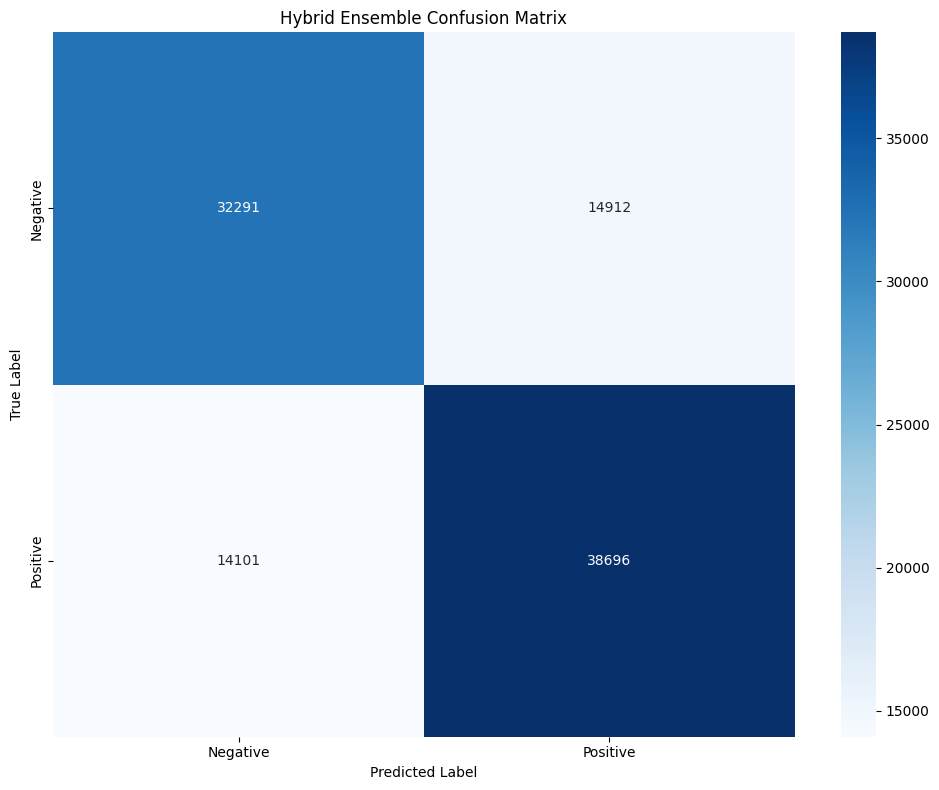

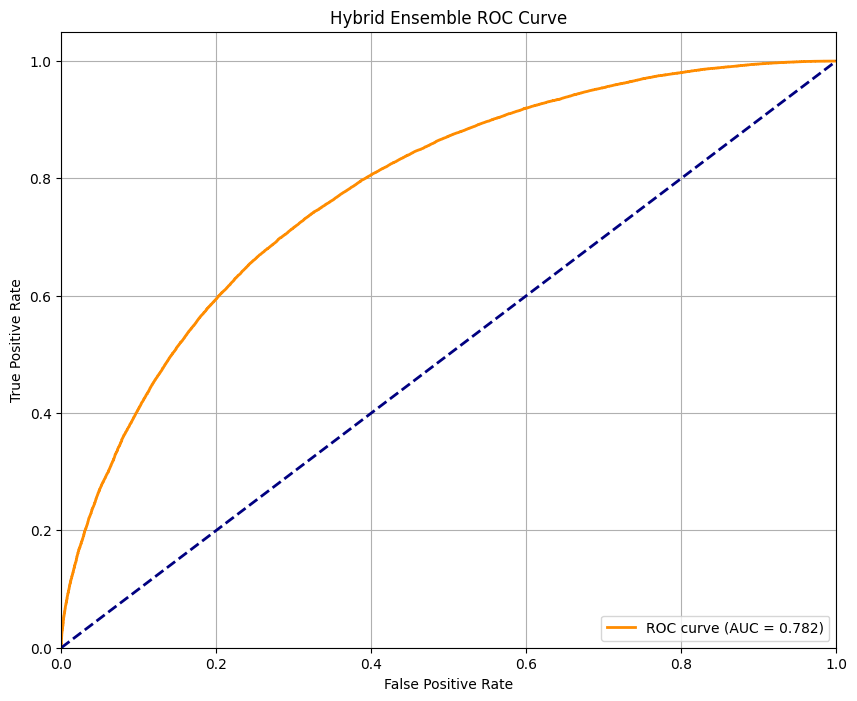


Detailed Evaluation Metrics:
--------------------------------------------------
AUC Score           : 0.7817
Optimal Threshold   : 0.5286
Precision           : 0.7218
Recall              : 0.7329
F1 Score            : 0.7273
Accuracy            : 0.7099


In [6]:
# test_metrics = evaluate_hybrid_ensemble(ensemble, test_loader)
# print("\nFinal Test Metrics:")
#     for metric, value in test_metrics.items():
#         print(f"{metric}: {value:.4f}")

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    auc
)
import numpy as np

def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    """
    Plot confusion matrix with percentages
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    
    # # Calculate percentages
    # cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # # Create annotation text|
    # annot = np.empty_like(cm, dtype=str)
    # nrows, ncols = cm.shape
    # for i in range(nrows):
    #     for j in range(ncols):
    #         annot[i, j] = f'{cm[i, j]}\n{cm_percent[i, j]:.1f}%'
    
    # Plot heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

def plot_roc_curve(y_true, y_pred_proba, title='ROC Curve'):
    """
    Plot ROC curve and display AUC score
    """
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
    
    return roc_auc

def evaluate_hybrid_ensemble(ensemble, test_loader, device='cuda', plot=True):
    """
    Evaluate the hybrid ensemble model with detailed metrics and plots
    """
    # ensemble.eval()
    
    # all_simple_preds = []
    # all_complex_preds = []
    # all_ensemble_preds = []
    # all_labels = []
    
    # with torch.no_grad():
    #     for features, labels in test_loader:
    #         # Move to device and ensure correct format
    #         features = features.float().to(device)
            
    #         # Add sequence dimension for transformer if needed
    #         if len(features.shape) == 2:
    #             features = features.unsqueeze(1)
            
    #         # Get predictions from simple model
    #         _, simple_clf = ensemble.simple_model(features)
    #         all_simple_preds.extend(simple_clf.squeeze().cpu().numpy())
            
    #         # Get predictions from complex model
    #         _, complex_clf = ensemble.complex_model(features)
    #         all_complex_preds.extend(complex_clf.squeeze().cpu().numpy())
            
    #         # Get ensemble predictions
    #         _, ensemble_clf = ensemble(features)
    #         all_ensemble_preds.extend(ensemble_clf.squeeze().cpu().numpy())
            
    #         # Store labels
    #         all_labels.extend(labels.numpy())
    
    # # Convert to numpy arrays
    # all_simple_preds = np.array(all_simple_preds)
    # all_complex_preds = np.array(all_complex_preds)
    # all_ensemble_preds = np.array(all_ensemble_preds)
    # all_labels = np.array(all_labels)
    
    # # Calculate ROC curves
    # fpr_simple, tpr_simple, _ = roc_curve(all_labels, all_simple_preds)
    # roc_auc_simple = auc(fpr_simple, tpr_simple)
    
    # fpr_complex, tpr_complex, _ = roc_curve(all_labels, all_complex_preds)
    # roc_auc_complex = auc(fpr_complex, tpr_complex)
    
    # fpr_ensemble, tpr_ensemble, thresholds = roc_curve(all_labels, all_ensemble_preds)
    # roc_auc_ensemble = auc(fpr_ensemble, tpr_ensemble)
    
    # # Plot ROC curves
    # plt.figure(figsize=(10, 8))
    # plt.plot(fpr_simple, tpr_simple, 
    #          label=f'Simple Model (AUC = {roc_auc_simple:.3f})')
    # plt.plot(fpr_complex, tpr_complex, 
    #          label=f'Complex Model (AUC = {roc_auc_complex:.3f})')
    # plt.plot(fpr_ensemble, tpr_ensemble, 
    #          label=f'Ensemble (AUC = {roc_auc_ensemble:.3f})')
    # plt.plot([0, 1], [0, 1], 'k--')
    # plt.xlabel('False Positive Rate')
    # plt.ylabel('True Positive Rate')
    # plt.title('ROC Curves Comparison')
    # plt.legend(loc='lower right')
    # plt.grid(True)
    # plt.show()
    
    # # Calculate optimal threshold and metrics for ensemble
    # optimal_idx = np.argmax(tpr_ensemble - fpr_ensemble)
    # optimal_threshold = thresholds[optimal_idx]
    # binary_preds = (all_ensemble_preds >= optimal_threshold).astype(int)
    
    # # Calculate metrics
    # metrics = {
    #     'AUC Score (Simple)': roc_auc_simple,
    #     'AUC Score (Complex)': roc_auc_complex,
    #     'AUC Score (Ensemble)': roc_auc_ensemble,
    #     'Optimal Threshold': optimal_threshold,
    #     'Precision': precision_score(all_labels, binary_preds),
    #     'Recall': recall_score(all_labels, binary_preds),
    #     'F1 Score': f1_score(all_labels, binary_preds),
    #     'Accuracy': accuracy_score(all_labels, binary_preds)
    # }
    
    # # Plot confusion matrix
    # plot_confusion_matrix(all_labels, binary_preds)
    
    # return metrics, all_ensemble_preds, all_labels


    ensemble.eval()
    all_preds_proba = []
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for features, labels in test_loader:
            features = features.to(device)
            labels = labels.to(device)
            
            # Get ensemble predictions
            _, classifications = ensemble(features)
            pred_proba = classifications.squeeze().cpu().numpy()
            
            all_preds_proba.extend(pred_proba)
            all_labels.extend(labels.cpu().numpy())
    
    # Convert to numpy arrays
    all_preds_proba = np.array(all_preds_proba)
    all_labels = np.array(all_labels)
    
    # Find optimal threshold using ROC curve
    fpr, tpr, thresholds = roc_curve(all_labels, all_preds_proba)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    
    # Get binary predictions using optimal threshold
    all_preds = (all_preds_proba >= optimal_threshold).astype(int)
    
    # Calculate metrics
    roc_auc = roc_auc_score(all_labels, all_preds_proba)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    accuracy = accuracy_score(all_labels, all_preds)
    
    # Store metrics
    metrics = {
        'AUC Score': roc_auc,
        'Optimal Threshold': optimal_threshold,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Accuracy': accuracy
    }
    
    if plot:
        # Plot confusion matrix
        plot_confusion_matrix(all_labels, all_preds, 
                            title='Hybrid Ensemble Confusion Matrix')
        
        # Plot ROC curve
        plot_roc_curve(all_labels, all_preds_proba, 
                      title='Hybrid Ensemble ROC Curve')
    
    return metrics, all_preds_proba, all_preds, all_labels

metrics, pred_proba, pred_binary, true_labels = evaluate_hybrid_ensemble(
        ensemble, test_loader, device, plot=True
    )
# metrics, predictions, true_labels = evaluate_hybrid_ensemble(
#             ensemble, test_loader, device
#         )
print("\nDetailed Evaluation Metrics:")
print("-" * 50)
for metric, value in metrics.items():
    print(f"{metric:20s}: {value:.4f}")

# plt.figure(figsize=(12, 8))

# test_features = (test_features).astype(np.float32)
# test_labels = (test_labels).astype(np.float32)

# Simple model ROC
# _, simple_clf = ensemble.simple_model(torch.tensor(test_features).to(device))
# _, simple_clf = ensemble.simple_model((test_features))

# simple_proba = simple_clf.cpu().detach().numpy()
# fpr_simple, tpr_simple, _ = roc_curve(true_labels, simple_proba)
# roc_auc_simple = auc(fpr_simple, tpr_simple)
    
# Complex model ROC
# _, complex_clf = ensemble.complex_model(torch.tensor(test_features).to(device))
# _, complex_clf = ensemble.complex_model((test_features))

# complex_proba = complex_clf.cpu().detach().numpy()
# fpr_complex, tpr_complex, _ = roc_curve(true_labels, complex_proba)
# roc_auc_complex = auc(fpr_complex, tpr_complex)
    
# Ensemble ROC
# fpr_ensemble, tpr_ensemble, _ = roc_curve(true_labels, pred_proba)
# roc_auc_ensemble = auc(fpr_ensemble, tpr_ensemble)
    
# Plot all ROC curves
# plt.plot(fpr_simple, tpr_simple, label=f'Simple Model (AUC = {roc_auc_simple:.3f})')
# plt.plot(fpr_complex, tpr_complexlabel=f'Complex Model (AUC = {roc_auc_complex:.3f})')
# plt.plot(fpr_ensemble, tpr_ensemble, label=f'Ensemble (AUC = {roc_auc_ensemble:.3f})')
# plt.plot([0, 1], [0, 1], 'k--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curves Comparison')
# plt.legend(loc='lower right')
# plt.grid(True)
# plt.show()

In [ ]:
# from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Final evaluation on test set
# model.eval()
# test_preds = []
# test_true = []
    
# with torch.no_grad():
#     for features, labels in test_loader:
#         features = features.to(device)
#         _, classification = model(features)
#         test_preds.extend(classification.squeeze().cpu().numpy())
#         test_true.extend(labels.numpy())

# y_true = np.array(test_true)
# y_scores = np.array(test_preds)

# fpr, tpr, thresholds = roc_curve(y_true, y_scores)
# roc_auc = auc(fpr, tpr)

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
# # Plot ROC curve
# ax1.plot(fpr, tpr, color='darkorange', lw=2,label=f'ROC curve (AUC = {roc_auc:.2f})')
# ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# ax1.set_xlim([0.0, 1.0])
# ax1.set_ylim([0.0, 1.05])
# ax1.set_xlabel('False Positive Rate')
# ax1.set_ylabel('True Positive Rate')
# ax1.set_title('Receiver Operating Characteristic (ROC) Curve')
# ax1.legend(loc="lower right")
    
# y_pred = (y_scores >= 0.5).astype(int)
    
# # Compute Confusion Matrix
# cm = confusion_matrix(y_true, y_pred)
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2)
# ax2.set_xlabel('Predicted Label')
# ax2.set_ylabel('True Label')
# ax2.set_title('Confusion Matrix')
    
# plt.tight_layout()
# plt.show()
    
# # Calculate additional metrics
# optimal_idx = np.argmax(tpr - fpr)
# optimal_threshold = thresholds[optimal_idx]
    
# # Compute precision, recall, F1 score
# from sklearn.metrics import precision_score, recall_score, f1_score
# precision = precision_score(y_true, y_pred)
# recall = recall_score(y_true, y_pred)
# f1 = f1_score(y_true, y_pred)
    
# print(f"AUC Score: {roc_auc:.4f}")
# print(f"Optimal Threshold: {optimal_threshold:.4f}")
# print(f"Precision: {precision:.4f}")
# print(f"Recall: {recall:.4f}")
# print(f"F1 Score: {f1:.4f}")
# print(f"Accuracy: {np.mean(y_pred == y_true):.4f}")



